In [4]:
# CNN Variants: Padding, Stride, Activation
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
tf.random.set_seed(SEED)

DATA_DIR = "chest_xray"
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dir = os.path.join(DATA_DIR, "train")
val_dir   = os.path.join(DATA_DIR, "val")
test_dir  = os.path.join(DATA_DIR, "test")

In [2]:
# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
class_names

# Optimise performance
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

print(f"Training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Training batches: 163
Validation batches: 1
Test batches: 20


In [5]:
# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

In [7]:
# Class Weights
normal_count = 1341
pneu_count = 3875
total = normal_count + pneu_count

class_weight = {
    0: total / (2 * normal_count),
    1: total / (2 * pneu_count),
}

print(f"Class weights: {class_weight}")
print(f"Normal class weight: {class_weight[0]:.3f}")
print(f"Pneumonia class weight: {class_weight[1]:.3f}")

Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}
Normal class weight: 1.945
Pneumonia class weight: 0.673


In [8]:
# Baseline Model
def build_baseline():
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0/255)(x)
    
    for f in (16, 32, 64):
        x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()]
    )
    return model

In [10]:
# Variant 1 — padding='valid'
def build_valid_padding():
    """
    VARIANT 1: VALID PADDING
    - Changed from padding='same' to padding='valid'
    - Reduces spatial dimensions faster
    - May lose edge information
    """
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0/255)(x)
    
    for f in (16, 32, 64):
        x = layers.Conv2D(f, 3, padding='valid', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()]
    )
    return model

In [11]:
# Variant 2 — First Conv2D uses strides=2
def build_stride2():
    """
    VARIANT 2: STRIDE-2 IN FIRST LAYER
    - First conv layer uses strides=2
    - Aggressive early downsampling
    - Should be faster but may lose fine details
    """
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0/255)(x)
    
    # First layer with stride=2
    x = layers.Conv2D(16, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    
    # Remaining layers unchanged
    for f in (32, 64):
        x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()]
    )
    return model

In [12]:
# Variant 3 — LeakyReLU activation
def build_leakyrelu():
    """
    VARIANT 3: LEAKY RELU ACTIVATION
    - Replaces ReLU with LeakyReLU (α=0.1)
    - Prevents dying ReLU problem
    - Allows small negative gradients
    """
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0/255)(x)
    
    for f in (16, 32, 64):
        x = layers.Conv2D(f, 3, padding='same')(x)
        x = layers.LeakyReLU(negative_slope=0.1)(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64)(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()]
    )
    return model

In [13]:
# Training function
def train_and_evaluate(model, model_name, epochs=10):
    """Train model with identical setup to baseline"""
    print(f"\n{'='*60}\nTraining: {model_name}\n{'='*60}")
    
    # IDENTICAL callbacks to baseline
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(f'best_{model_name}.keras', save_best_only=True),
    ]
    
    start_time = time.time()
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1
    )
    
    train_time = time.time() - start_time
    n_epochs = len(history.history['loss'])
    
    return {
        'name': model_name,
        'val_acc': history.history['val_accuracy'][-1],
        'val_loss': history.history['val_loss'][-1],
        'train_acc': history.history['accuracy'][-1],
        'train_loss': history.history['loss'][-1],
        'epochs': n_epochs,
        'time_per_epoch': train_time / n_epochs,
        'total_time': train_time,
        'history': history.history
    }

In [14]:
# Experiments
results = []

# Baseline Model
model = build_baseline()
results.append(train_and_evaluate(model, 'baseline'))
del model
tf.keras.backend.clear_session()

# Variant 1: Valid padding
model = build_valid_padding()
results.append(train_and_evaluate(model, 'valid_padding'))
del model
tf.keras.backend.clear_session()

# Variant 2: Stride-2
model = build_stride2()
results.append(train_and_evaluate(model, 'stride2'))
del model
tf.keras.backend.clear_session()

# Variant 3: LeakyReLU
model = build_leakyrelu()
results.append(train_and_evaluate(model, 'leakyrelu'))
del model
tf.keras.backend.clear_session()


Training: baseline
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.7138 - auc: 0.8536 - loss: 0.5045 - precision: 0.9447 - recall: 0.6529 - val_accuracy: 0.5000 - val_auc: 0.6250 - val_loss: 0.7478 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.8447 - auc: 0.9216 - loss: 0.3619 - precision: 0.9677 - recall: 0.8183 - val_accuracy: 0.5000 - val_auc: 0.6562 - val_loss: 1.3047 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 358ms/step - accuracy: 0.8597 - auc: 0.9352 - loss: 0.3214 - precision: 0.9704 - recall: 0.8366 - val_accuracy: 0.5000 - val_auc: 0.6094 - val_loss: 1.4936 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.8777 - auc: 0.9430 - loss: 0.2957 - precision: 0.9731 - recall: 0.8591 - val_accuracy: 0.6250 - val_auc: 0.7344 - val_loss: 0.9071 - val_precision: 0.5714 - val_recall: 1.0000


In [15]:
# Comparative Analysis
df = pd.DataFrame([{
    'Model': r['name'],
    'Val Acc': f"{r['val_acc']:.4f}",
    'Val Loss': f"{r['val_loss']:.4f}",
    'Train Acc': f"{r['train_acc']:.4f}",
    'Time/Epoch (s)': f"{r['time_per_epoch']:.1f}",
    'Epochs': r['epochs'],
    'Overfit Gap': f"{r['train_acc'] - r['val_acc']:+.3f}"
} for r in results])

print("\n" + "="*80)
print("RESULTS: PADDING, STRIDE, ACTIVATION COMPARISON")
print("="*80 + "\n")
print(df.to_string(index=False))

# Key findings
best = max(results, key=lambda x: x['val_acc'])
fastest = min(results, key=lambda x: x['time_per_epoch'])
baseline = results[0]

print(f"\n{'='*80}")
print("KEY FINDINGS")
print(f"{'='*80}")
print(f"Best validation accuracy: {best['name']} ({best['val_acc']:.4f})")
print(f"Fastest training: {fastest['name']} ({fastest['time_per_epoch']:.1f}s/epoch)")
print(f"Speedup vs baseline: {baseline['time_per_epoch']/fastest['time_per_epoch']:.2f}x")
print(f"\nPadding impact: {results[1]['val_acc'] - baseline['val_acc']:+.4f}")
print(f"Stride-2 impact: {results[2]['val_acc'] - baseline['val_acc']:+.4f}")
print(f"LeakyReLU impact: {results[3]['val_acc'] - baseline['val_acc']:+.4f}")

# Save
df.to_csv('results.csv', index=False)
print(f"\n✓ Results saved to results.csv")


RESULTS: PADDING, STRIDE, ACTIVATION COMPARISON

        Model Val Acc Val Loss Train Acc Time/Epoch (s)  Epochs Overfit Gap
     baseline  0.6250   0.9071    0.8777           29.3       4      +0.253
valid_padding  0.6250   1.1983    0.8832           29.7       4      +0.258
      stride2  0.6250   1.0532    0.8878            9.4       4      +0.263
    leakyrelu  0.5000   1.1443    0.8938           19.7       8      +0.394

KEY FINDINGS
Best validation accuracy: baseline (0.6250)
Fastest training: stride2 (9.4s/epoch)
Speedup vs baseline: 3.11x

Padding impact: +0.0000
Stride-2 impact: +0.0000
LeakyReLU impact: -0.1250

✓ Results saved to results.csv


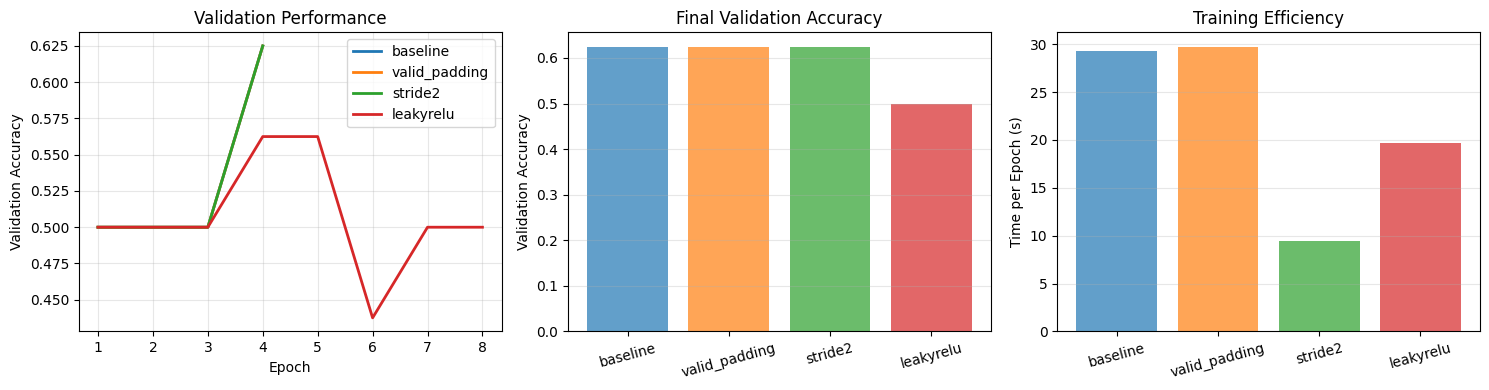

✓ Figure saved to comparison.png


In [17]:
# Visualisation of Training Curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Validation curves
for i, r in enumerate(results):
    epochs = range(1, r['epochs'] + 1)
    axes[0].plot(epochs, r['history']['val_accuracy'], 
                label=r['name'], color=colors[i], linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Validation Performance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Final validation accuracy
names = [r['name'] for r in results]
val_accs = [r['val_acc'] for r in results]
axes[1].bar(names, val_accs, color=colors, alpha=0.7)
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Final Validation Accuracy')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(True, alpha=0.3, axis='y')

# Training efficiency
times = [r['time_per_epoch'] for r in results]
axes[2].bar(names, times, color=colors, alpha=0.7)
axes[2].set_ylabel('Time per Epoch (s)')
axes[2].set_title('Training Efficiency')
axes[2].tick_params(axis='x', rotation=15)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved to comparison.png")